# IO 2, Problem Set 3

#### Abram and Higbee

In [1]:
# Set wd
pwd()
dir = "/Users/JoshuaHigbee/Box/2. Second Year/2. Winter Quarter - 2021/" * 
        "Industrial Organization II - Hortacsu/Problem Sets/Problem Set 3/";
cd(dir);

# Set up packages (must have pre-loaded)
using Pkg
using CSV, DataFrames, Random, Distributions, LinearAlgebra, LatexPrint, StatsBase, Plots, SpecialFunctions
using Optim, ForwardDiff, PyCall, ShiftedArrays, StatsPlots, DataFramesMeta, FixedEffectModels, QuadGK

# Set seed
Random.seed!(12345);

# Set column and row views
#ENV["COLUMNS"]=10000; ENV["ROWS"]=10000;
Base.displaysize() = (100, 100000);

<br><br><br><br>

# 1. Data

In [2]:
dt = CSV.read("ps3clean.csv", DataFrame);
println(size(dt))

(2636, 21)


In [3]:
rename!(dt, [:data_num, :bidder, :house, :date, :lot, :profit, :net_pay, :rank, :p_final, :bid,
                :est_min_d, :est_max_d, :catalog_p, :catalog_d, :est_min, :est_max, :grade_min,
                :grade_max, :no_grade, :excl_us, :no_value]);

In [4]:
dt.auction_num = groupindices(groupby(dt, [:house, :date, :lot]));

In [5]:
dt[!, :num_bidders] .= 0
for i in unique(dt.auction_num)
    dt[dt.auction_num .== i, :num_bidders] .= nrow(dt[dt.auction_num .== i, :])
end;

In [6]:
dt.lot_value = dt.catalog_d .* dt.catalog_p .+ (1 .- dt.catalog_d) .* 0.5 .* (dt.est_min .+ dt.est_max);

In [7]:
first(dt, 10)

,data_num,bidder,house,date,lot,profit,net_pay,rank,p_final,bid,est_min_d,est_max_d,catalog_p,catalog_d,est_min,est_max,grade_min,grade_max,no_grade,excl_us,no_value,auction_num,num_bidders,lot_value
,Int64,Int64,String,Int64,String,Float64,Float64,Int64,Int64,Int64,Int64,Int64,Float64,Int64,Float64,Float64,Int64?,Int64,Int64,Int64,Int64,Int64?,Int64,Float64
1,1,1,A,35360,217,150.0,-150.0,1,5200,8000,7000,9000,0.0,0,7000.0,9000.0,3,2,0,1,0,1,2,8000.0
2,2,2,A,35360,217,150.0,150.0,2,5200,5500,7000,9000,0.0,0,7000.0,9000.0,3,2,0,1,0,1,2,8000.0
3,3,1,A,35360,218,0.0,0.0,1,1000,950,300,400,0.0,0,300.0,400.0,5,2,0,1,0,2,1,350.0
4,4,1,A,35360,220,0.0,0.0,1,1500,1500,1000,1200,0.0,0,1000.0,1200.0,5,2,0,1,0,3,1,1100.0
5,5,1,A,35360,222,0.0,0.0,1,4800,4750,4000,5000,0.0,0,4000.0,5000.0,3,2,0,1,0,4,1,4500.0
6,6,1,A,35360,350,0.0,0.0,1,2200,2100,800,1000,0.0,0,800.0,1000.0,3,2,0,0,0,5,3,900.0
7,7,2,A,35360,350,0.0,0.0,2,2200,1700,800,1000,0.0,0,800.0,1000.0,3,2,0,0,0,5,3,900.0
8,8,3,A,35360,350,0.0,0.0,3,2200,1050,800,1000,0.0,0,800.0,1000.0,3,2,0,0,0,5,3,900.0
9,9,1,A,35360,351,0.0,0.0,1,1400,550,1000,1200,0.0,0,1000.0,1200.0,2,2,0,0,0,6,1,1100.0


<br><br>

### Table 1

In [8]:
houses = unique(dt.house)
tab_1 = DataFrame(house = houses, tgt_mean = fill(0,6), tgt_sd = fill(0,6), knock_mean = fill(0,6), 
    knock_sd = fill(0,6), perc_lots_won = fill(0,6), perc_val_won = fill(0,6), num_lots = fill(0,6), 
    num_sales = fill(0,6))

for house in houses

    # Get data
    dt_h = dt[dt.house .== house, :]
    dt_h1 = dt_h[dt_h.rank .== 1, :]
    
    # Target auction values
    tab_1[tab_1.house .== house, :tgt_mean] .= Int(round(mean(dt_h.p_final), digits=0))
    tab_1[tab_1.house .== house, :tgt_sd] .= Int(round(std(dt_h.p_final), digits=0))
    
    # Knockout auction values
    tab_1[tab_1.house .== house , :knock_mean] .= 
        Int(round(mean(dt_h[dt_h.rank .== 1, :bid]), digits=0))
    tab_1[tab_1.house .== house, :knock_sd] .= 
        Int(round(std(dt_h[dt_h.rank .== 1, :bid]), digits=0))
    
    # Perc of lots/value won by ring
    tab_1[tab_1.house .== house , :perc_lots_won] .= 
        Int(round.(mean(100*(dt_h1.bid .≥ dt_h1.p_final)), digits=0))
    tab_1[tab_1.house .== house , :perc_val_won] .= 
        Int(round.(100*sum(dt_h1[dt_h1.bid .≥ dt_h1.p_final, :lot_value])/sum(dt_h1.lot_value), digits=0))
    
    # Number of lots and sales
    tab_1[tab_1.house .== house , :num_lots] .= nrow(dt_h1)
    tab_1[tab_1.house .== house , :num_sales] .= length(unique(dt_h1.date))
end;

In [9]:
tab_1

,house,tgt_mean,tgt_sd,knock_mean,knock_sd,perc_lots_won,perc_val_won,num_lots,num_sales
,String,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,A,1531,1572,1534,1988,28,48,29,1
2,B,1174,1606,1686,4009,65,43,37,1
3,C,1388,1933,1257,2739,63,66,413,2
4,D,1424,1584,1219,1924,46,52,153,1
5,E,3141,2918,5562,6812,87,95,127,1
6,F1,2036,3057,2023,4195,48,61,100,2


<br><br>

### Table 2

In [10]:
bid_nums = sort(unique(dt.num_bidders))
tab_2 = DataFrame(num_bids = bid_nums, tgt_mean = fill(0,8), tgt_sd = fill(0,8), knock_mean = fill(0,8), 
    knock_sd = fill(0,8), perc_lots_won = fill(0,8), num_lots = fill(0,8))

for bid in bid_nums

    # Get data
    dt_b = dt[dt.num_bidders .== bid, :]
    dt_b1 = dt_b[dt_b.rank .== 1, :]
    
    # Target auction values
    tab_2[tab_2.num_bids .== bid, :tgt_mean] .= Int(round(mean(dt_b.p_final), digits=0))
    tab_2[tab_2.num_bids .== bid, :tgt_sd] .= Int(round(std(dt_b.p_final), digits=0))
    
    # Knockout auction values
    tab_2[tab_2.num_bids .== bid, :knock_mean] .= 
        Int(round(mean(dt_b[dt_b.rank .== 1, :bid]), digits=0))
    tab_2[tab_2.num_bids .== bid, :knock_sd] .= 
        Int(round(std(dt_b[dt_b.rank .== 1, :bid]), digits=0))
    
    # Perc of lots/value won by ring
    tab_2[tab_2.num_bids .== bid, :perc_lots_won] .= 
        Int(round.(mean(100*(dt_b1.bid .≥ dt_b1.p_final)), digits=0))
    
    # Number of lots and sales
    tab_2[tab_2.num_bids .== bid, :num_lots] .= nrow(dt_b1)
end;

In [11]:
tab_2

,num_bids,tgt_mean,tgt_sd,knock_mean,knock_sd,perc_lots_won,num_lots
,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,1,567,862,497,899,28,267
2,2,991,1800,1183,3612,59,149
3,3,1221,1508,1437,1969,68,127
4,4,2030,2815,3062,5857,77,110
5,5,1755,2319,2921,4938,84,79
6,6,2327,3121,3952,5600,89,55
7,7,2722,2036,5305,4326,96,51
8,8,4290,2501,8293,4676,95,21


<br><br><br><br>

# 2. Introductory Questions

### Table 5

In [12]:
first(dt, 10)

,data_num,bidder,house,date,lot,profit,net_pay,rank,p_final,bid,est_min_d,est_max_d,catalog_p,catalog_d,est_min,est_max,grade_min,grade_max,no_grade,excl_us,no_value,auction_num,num_bidders,lot_value
,Int64,Int64,String,Int64,String,Float64,Float64,Int64,Int64,Int64,Int64,Int64,Float64,Int64,Float64,Float64,Int64?,Int64,Int64,Int64,Int64,Int64?,Int64,Float64
1,1,1,A,35360,217,150.0,-150.0,1,5200,8000,7000,9000,0.0,0,7000.0,9000.0,3,2,0,1,0,1,2,8000.0
2,2,2,A,35360,217,150.0,150.0,2,5200,5500,7000,9000,0.0,0,7000.0,9000.0,3,2,0,1,0,1,2,8000.0
3,3,1,A,35360,218,0.0,0.0,1,1000,950,300,400,0.0,0,300.0,400.0,5,2,0,1,0,2,1,350.0
4,4,1,A,35360,220,0.0,0.0,1,1500,1500,1000,1200,0.0,0,1000.0,1200.0,5,2,0,1,0,3,1,1100.0
5,5,1,A,35360,222,0.0,0.0,1,4800,4750,4000,5000,0.0,0,4000.0,5000.0,3,2,0,1,0,4,1,4500.0
6,6,1,A,35360,350,0.0,0.0,1,2200,2100,800,1000,0.0,0,800.0,1000.0,3,2,0,0,0,5,3,900.0
7,7,2,A,35360,350,0.0,0.0,2,2200,1700,800,1000,0.0,0,800.0,1000.0,3,2,0,0,0,5,3,900.0
8,8,3,A,35360,350,0.0,0.0,3,2200,1050,800,1000,0.0,0,800.0,1000.0,3,2,0,0,0,5,3,900.0
9,9,1,A,35360,351,0.0,0.0,1,1400,550,1000,1200,0.0,0,1000.0,1200.0,2,2,0,0,0,6,1,1100.0


In [13]:
bidders = sort(unique(dt.bidder))
tab_5 = DataFrame(ring_member = bidders, perc_high = fill(0,11), num_knock = fill(0,11), 
    perc_high_p2 = fill(0,11), perc_rec_sp_p2 = fill(0,11), perc_pay_sp_p2 = fill(0,11), 
    num_knock_p2 = fill(0,11))

for bidder in bidders

    # Get data
    dt_b = dt[dt.bidder .== bidder, :]
    dt_b_p2 = dt_b[(dt_b.bidder .== bidder) .& (dt_b.num_bidders .≥ 2), :]
    
    # All auctions
    tab_5[tab_5.ring_member .== bidder, :perc_high] .= 
        Int(round.(mean(100*(dt_b.rank .== 1)), digits=0))
    tab_5[tab_5.ring_member .== bidder, :num_knock] .= 
        Int(round.(sum((dt_b.rank .== 1)), digits=0))
    
    # All auctions
    tab_5[tab_5.ring_member .== bidder, :perc_high_p2] .= 
        Int(round.(mean(100*(dt_b_p2.rank .== 1)), digits=0))
    tab_5[tab_5.ring_member .== bidder, :perc_rec_sp_p2] .= 
        Int(round.(mean(100*(dt_b_p2.net_pay .> 1)), digits=0))
    tab_5[tab_5.ring_member .== bidder, :perc_pay_sp_p2] .= 
        Int(round.(mean(100*(dt_b_p2.net_pay .< 1)), digits=0))
    tab_5[tab_5.ring_member .== bidder, :num_knock_p2] .= 
        Int(round.(sum((dt_b_p2.rank .== 1)), digits=0))
end;

In [14]:
tab_5

,ring_member,perc_high,num_knock,perc_high_p2,perc_rec_sp_p2,perc_pay_sp_p2,num_knock_p2
,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,1,40,260,24,23,77,125
2,2,10,35,8,24,76,30
3,3,38,148,27,29,71,93
4,4,27,88,26,29,71,83
5,5,38,101,23,24,76,51
6,6,46,71,46,14,86,70
7,7,41,96,40,26,74,91
8,8,17,5,4,35,65,1
9,9,48,37,45,29,71,33


### Figure 1

In [15]:
bidders = sort(unique(dt.bidder))
fig_1_tab = DataFrame(ring_member = bidders, net_pay_all = fill(0.0,11), net_pay_small_auct = fill(0.0,11))

for bidder in bidders

    # Get data
    dt_b = dt[dt.bidder .== bidder, :]
    dt_b_sa = dt_b[(dt_b.bidder .== bidder) .& (dt_b.p_final .≤ 10000), :]
    
    # All auctions
    fig_1_tab[tab_5.ring_member .== bidder, :net_pay_all] .= sum(dt_b.net_pay)
    fig_1_tab[tab_5.ring_member .== bidder, :net_pay_small_auct] .= sum(dt_b_sa.net_pay)
end;

In [16]:
fig_1_tab

,ring_member,net_pay_all,net_pay_small_auct
,Int64,Float64,Float64
1,1,12882.2,16132.2
2,2,8590.73,7507.4
3,3,14588.5,12234.3
4,4,-7078.9,-7933.07
5,5,1463.14,1463.14
6,6,-4806.73,-4806.73
7,7,-53016.2,-37016.2
8,8,880.31,880.31
9,9,5478.21,-6480.12


In [17]:
payments = vec(reshape(Matrix(fig_1_tab[:, [:net_pay_all, :net_pay_small_auct]]), 22, 1));
auct_type = repeat(["All Auctions", "Small Auctions"], inner=11);
names = repeat([" 1", " 2", " 3", " 4", " 5", " 6", " 7", " 8", " 9", "10", "11"], outer = 2);

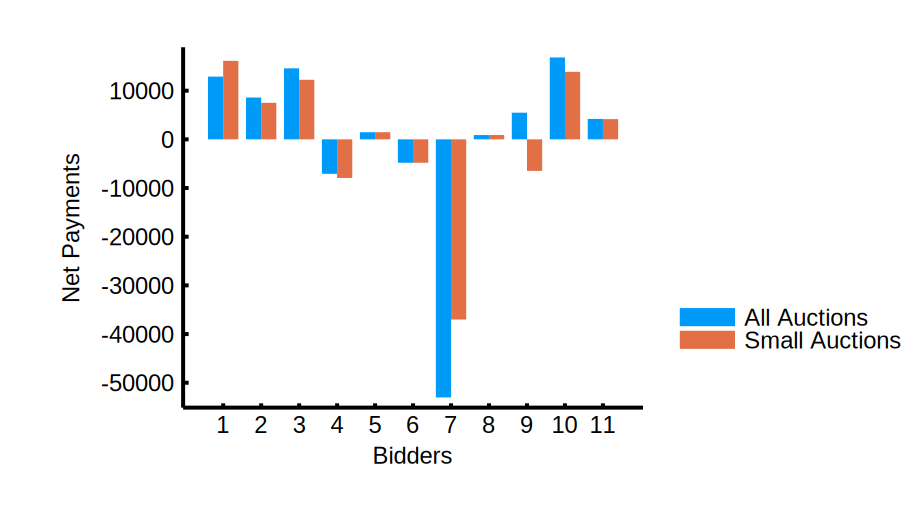

In [24]:
fig = groupedbar(names, payments, group = auct_type, ylabel = "Net Payments", title = "",
        legendfont=font(3), xtickfont=font(4), ytickfont=font(4), guidefont=font(4), line=0,
        foreground_color_legend=nothing, background_color_legend=nothing, grid=false,
        legend=:outerright, xlabel = "Bidders", yformatter = :plain)
plot!(size=(230,130))
savefig("fig_5.png")
fig

#### Remove auctions with more than 2 ring bidders

In [19]:
dt = dt[dt.num_bidders .≤ 2, :];

In [20]:
size(dt)

(565, 24)

<br><br><br><br>

# 3. Structural Analysis

## Step 1

### Normalize the bids

Predict bids

Normalize bids

In [184]:
dt_b = dt[:, [:auction_num, :bidder, :rank, :bid, :p_final, :est_min, :est_max, 
                :catalog_p, :grade_min, :grade_max, :excl_us, :no_value]]
println(size(dt_b))
first(dt_b, 10)

(565, 12)


,auction_num,bidder,rank,bid,p_final,est_min,est_max,catalog_p,grade_min,grade_max,excl_us,no_value
,Int64?,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Int64?,Int64,Int64,Int64
1,1,1,1,8000,5200,7000.0,9000.0,0.0,3,2,1,0
2,1,2,2,5500,5200,7000.0,9000.0,0.0,3,2,1,0
3,2,1,1,950,1000,300.0,400.0,0.0,5,2,1,0
4,3,1,1,1500,1500,1000.0,1200.0,0.0,5,2,1,0
5,4,1,1,4750,4800,4000.0,5000.0,0.0,3,2,1,0
6,6,1,1,550,1400,1000.0,1200.0,0.0,2,2,0,0
7,7,1,1,340,200,300.0,400.0,0.0,3,2,0,0
8,9,2,1,120,130,180.0,200.0,0.0,3,2,0,0
9,12,1,1,300,850,350.0,450.0,0.0,3,2,0,0


Flag auctions where ring wins

In [185]:
dt_b[:, :ring_wins] .= 0.0
for i in unique(dt_b.auction_num)
    dt_b[dt_b.auction_num .== i, :ring_wins] .= 1.0*(dt_b[(dt_b.auction_num .== i) .& (dt_b.rank .== 1), 
            :p_final] .≤ dt_b[(dt_b.auction_num .== i) .& (dt_b.rank .== 1), :bid])
end;

In [186]:
for i in unique(dt_b.auction_num)
    row = dt_b[(dt_b.auction_num .== i) .& (dt_b.rank .== 1), :]
    row[2] = 100
    row[4] = row[5]
    append!(dt_b, row)
end;
dt_b = sort!(dt_b, [:auction_num, :bidder])
dt_b[:, :log_bid] = log.(dt_b.bid)
println(size(dt_b))
first(dt_b, 10)

(981, 14)


,auction_num,bidder,rank,bid,p_final,est_min,est_max,catalog_p,grade_min,grade_max,excl_us,no_value,ring_wins,log_bid
,Int64?,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Int64?,Int64,Int64,Int64,Float64,Float64
1,1,1,1,8000,5200,7000.0,9000.0,0.0,3,2,1,0,1.0,8.9872
2,1,2,2,5500,5200,7000.0,9000.0,0.0,3,2,1,0,1.0,8.6125
3,1,100,1,5200,5200,7000.0,9000.0,0.0,3,2,1,0,1.0,8.55641
4,2,1,1,950,1000,300.0,400.0,0.0,5,2,1,0,0.0,6.85646
5,2,100,1,1000,1000,300.0,400.0,0.0,5,2,1,0,0.0,6.90776
6,3,1,1,1500,1500,1000.0,1200.0,0.0,5,2,1,0,1.0,7.31322
7,3,100,1,1500,1500,1000.0,1200.0,0.0,5,2,1,0,1.0,7.31322
8,4,1,1,4750,4800,4000.0,5000.0,0.0,3,2,1,0,0.0,8.4659
9,4,100,1,4800,4800,4000.0,5000.0,0.0,3,2,1,0,0.0,8.47637


Regression with dummies for bidders (including outside bidders) and each auction number

In [187]:
b_reg = reg(dt_b, @formula(log_bid ~ est_min + est_max + catalog_p + grade_min + grade_max +
                    excl_us + no_value + fe(bidder) + fe(auction_num)))

                            Fixed Effect Model                            
Number of obs:                   979   Degrees of freedom:              434
R2:                            0.933   R2 Adjusted:                   0.879
F Statistic:             2.27334e-14   p-value:                       1.000
R2 within:                     0.000   Iterations:                       17
Converged:                      true   
              Estimate Std.Error      t value Pr(>|t|)  Lower 95% Upper 95%
---------------------------------------------------------------------------
est_min    -8.40274e-8   210.534 -3.99116e-10    1.000   -413.557   413.557
est_max    -1.80301e-5   237.981  -7.57626e-8    1.000   -467.473   467.473
catalog_p   0.00036413   2367.13   1.53828e-7    1.000   -4649.82   4649.82
grade_min    -0.299193  1.3707e6  -2.18277e-7    1.000 -2.69251e6 2.69251e6
grade_max   -0.0363337  207744.0  -1.74896e-7    1.000  -408077.0 4.08077e5
excl_us      -0.564392 3.15406e6  -1.78942e-7    

In [188]:
b_reg.coef

7-element Array{Float64,1}:
 -8.40273804931652e-8
 -1.8030076637523742e-5
  0.00036413030888500703
 -0.299193335991288
 -0.036333687224308325
 -0.564392297495673
  0.054879874109813265

Now running with "target auction" bidder and "individual ring members" dummies, so 12 total dummies.

In [189]:
b_reg = reg(dt_b, @formula(log_bid ~ est_min + est_max + catalog_p + grade_min + grade_max +
                    excl_us + no_value + fe(bidder)))

                              Fixed Effect Model                              
Number of obs:                     979   Degrees of freedom:                 19
R2:                              0.480   R2 Adjusted:                     0.470
F Statistic:                   108.182   p-value:                         0.000
R2 within:                       0.441   Iterations:                          1
Converged:                        true   
              Estimate   Std.Error   t value Pr(>|t|)    Lower 95%    Upper 95%
-------------------------------------------------------------------------------
est_min    0.000564641 0.000216992   2.60213    0.009  0.000138808  0.000990475
est_max     4.30127e-5 0.000160081  0.268694    0.788 -0.000271136  0.000357161
catalog_p  -0.00041597  6.21659e-5   -6.6913    0.000 -0.000537967 -0.000293974
grade_min    0.0588739   0.0240542   2.44756    0.015    0.0116691     0.106079
grade_max   -0.0153202    0.028283 -0.541676    0.588   -0.0708239    0.0401834

In [190]:
b_reg.coef

7-element Array{Float64,1}:
  0.0005646411859012532
  4.301270745790618e-5
 -0.0004159703322504552
  0.058873861553100836
 -0.015320224813137592
 -0.014261378096007514
 -0.09270047994324666

In [191]:
dt_b[:, :b_norm] = dt_b.log_bid .- Matrix(dt_b[:, [:est_min, :est_max, :catalog_p, :grade_min, :grade_max, 
                            :excl_us, :no_value]]) * b_reg.coef
first(dt_b, 10)

,auction_num,bidder,rank,bid,p_final,est_min,est_max,catalog_p,grade_min,grade_max,excl_us,no_value,ring_wins,log_bid,b_norm
,Int64?,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Int64?,Int64,Int64,Int64,Float64,Float64,Float64?
1,1,1,1,8000,5200,7000.0,9000.0,0.0,3,2,1,0,1.0,8.9872,4.51587
2,1,2,2,5500,5200,7000.0,9000.0,0.0,3,2,1,0,1.0,8.6125,4.14118
3,1,100,1,5200,5200,7000.0,9000.0,0.0,3,2,1,0,1.0,8.55641,4.08509
4,2,1,1,950,1000,300.0,400.0,0.0,5,2,1,0,0.0,6.85646,6.4204
5,2,100,1,1000,1000,300.0,400.0,0.0,5,2,1,0,0.0,6.90776,6.47169
6,3,1,1,1500,1500,1000.0,1200.0,0.0,5,2,1,0,1.0,7.31322,6.4475
7,3,100,1,1500,1500,1000.0,1200.0,0.0,5,2,1,0,1.0,7.31322,6.4475
8,4,1,1,4750,4800,4000.0,5000.0,0.0,3,2,1,0,0.0,8.4659,5.86055
9,4,100,1,4800,4800,4000.0,5000.0,0.0,3,2,1,0,0.0,8.47637,5.87102


In [193]:
dt_b = dt_b[ismissing.(dt_b.b_norm) .== 0, :];

<br><br><br><br>

## Step 3

Determine evaluation grid for all distributions (using 50-1050 as the shared support, since it is approximately what is in the Asker paper and contains most of the points without having too thin support in some areas)

In [401]:
evals_pts = LinRange(50,1050,1000);

Write kernel density estimation functions

In [402]:
bw_silv = function(x)
    n = length(x)
    m = min(std(x), iqr(x)/1.349)
    h = 0.9 * m / n^0.2
    return h
end;

In [403]:
est_pdf = function(x, eval_pts)
    h = bw_silv(x)
    return 1 / h * mean([pdf(Normal(), (eval_pts .- x_i) ./ h) for x_i in x])
end;

In [404]:
est_cdf = function(x, eval_pts)
    h = bw_silv(x)
    return mean([cdf(Normal(), (eval_pts .- x_i) ./ h) for x_i in x])
end;

### Estimate $\bar{H}_r$

In [405]:
H̄r_bids_obs = exp.(dt_b[(dt_b.bidder .== 100) .& (dt_b.ring_wins .== 1.0), :b_norm]);
pdf_H̄r = est_pdf(H̄r_bids_obs, evals_pts);

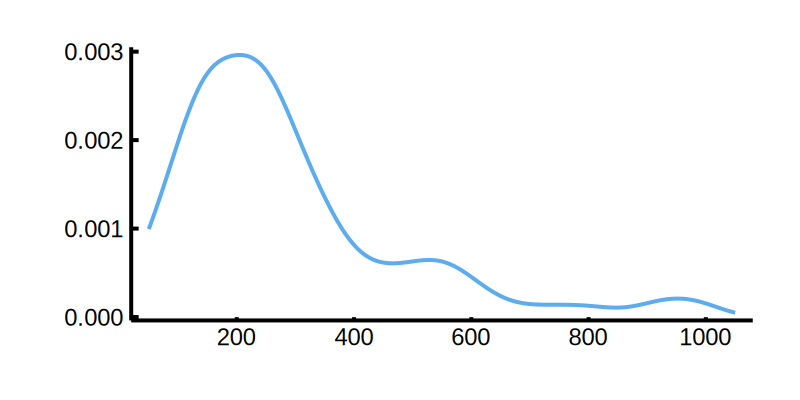

In [406]:
fig = plot(evals_pts, pdf_H̄r, linecolor=:steelblue2, linewidth=1, 
        xtickfont=font(4), ytickfont=font(4), legend=nothing,
        foreground_color_legend=nothing, background_color_legend=nothing, grid=false)
plot!(size=(200,100))
savefig("pdf_Hbar_r.png")
fig

In [407]:
cdf_H̄r = est_cdf(H̄r_bids_obs, evals_pts);

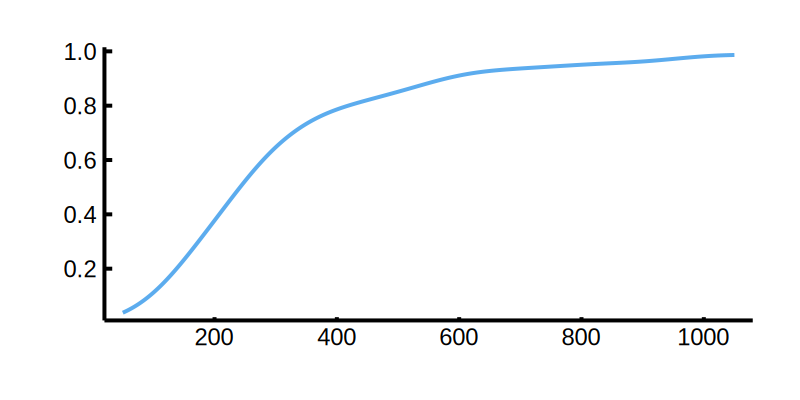

In [408]:
fig = plot(evals_pts, cdf_H̄r, linecolor=:steelblue2, linewidth=1, 
        xtickfont=font(4), ytickfont=font(4), legend=nothing,
        foreground_color_legend=nothing, background_color_legend=nothing, grid=false)
plot!(size=(200,100))
savefig("cdf_Hbar_r.png")
fig

### Estimate $G_m$

In [409]:
Gm_bids_obs = exp.(dt_b[(dt_b.bidder .!= 100) .& (dt_b.rank .== 1), :b_norm]);
pdf_Gm = est_pdf(Gm_bids_obs, evals_pts);

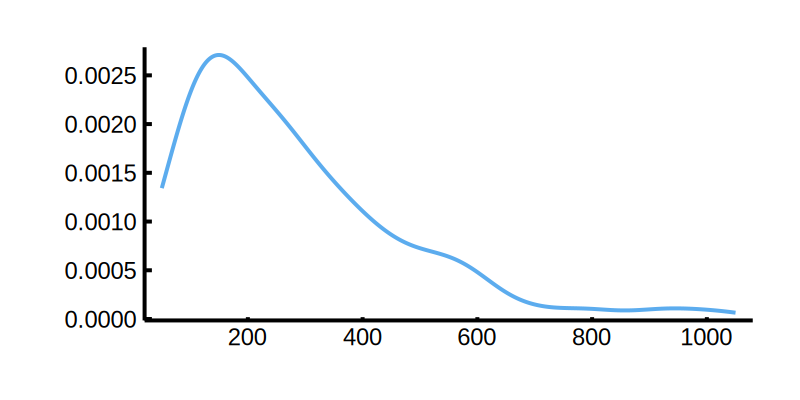

In [410]:
fig = plot(evals_pts, pdf_Gm, linecolor=:steelblue2, linewidth=1, 
        xtickfont=font(4), ytickfont=font(4), legend=nothing,
        foreground_color_legend=nothing, background_color_legend=nothing, grid=false)
plot!(size=(200,100))
savefig("pdf_Gm.png")
fig

In [411]:
cdf_Gm = est_cdf(Gm_bids_obs, evals_pts);

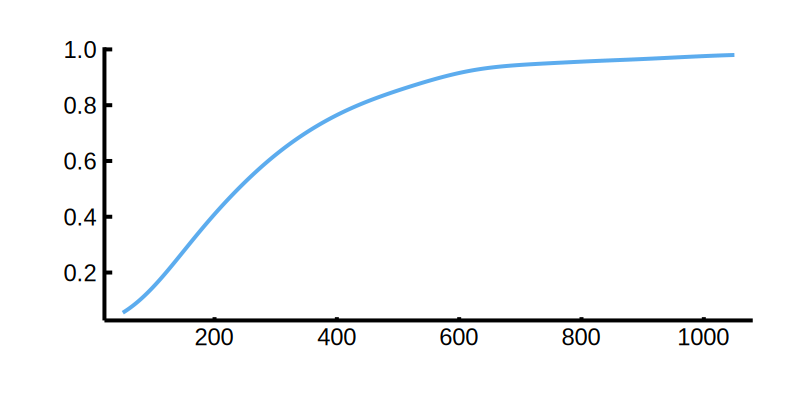

In [412]:
fig = plot(evals_pts, cdf_Gm, linecolor=:steelblue2, linewidth=1, 
        xtickfont=font(4), ytickfont=font(4), legend=nothing,
        foreground_color_legend=nothing, background_color_legend=nothing, grid=false)
plot!(size=(200,100))
savefig("cdf_Gm.png")
fig

### Estimate $H_r$

Construct functions for estimation

In [413]:
fn_pdf_h = function(h_bids, g_bids, eval_pts)
    frac(x) = est_pdf(h_bids, x) ./ (1 .- est_cdf(g_bids, x))
    A = (quadgk(frac, -Inf, 1.0*maximum(eval_pts), rtol=1e-4)[1])^(-1)
    return A .* frac.(eval_pts)
end;

In [414]:
fn_cdf_h = function(h_bids, g_bids, eval_pts)
    frac(x) = est_pdf(h_bids, x) ./ (1 .- est_cdf(g_bids, x))
    A = (quadgk(frac, -Inf, 1.0*maximum(eval_pts), rtol=1e-4)[1])^(-1)
    integral = zeros(length(eval_pts))
    for i in 1:length(integral)
        integral[i] = quadgk(frac, -Inf, 1.0*eval_pts[i], rtol=1e-4)[1]
    end
    return A .* integral
end;

Estimate PDF

In [415]:
pdf_Hr = fn_pdf_h(H̄r_bids_obs, Gm_bids_obs, evals_pts);

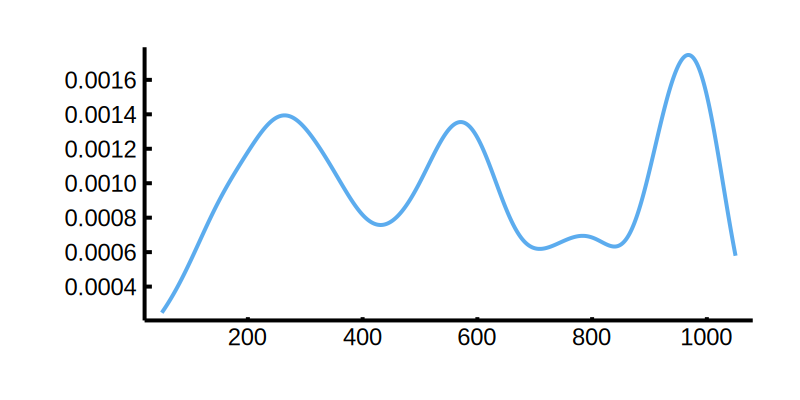

In [416]:
fig = plot(evals_pts, pdf_Hr, linecolor=:steelblue2, linewidth=1, 
        xtickfont=font(4), ytickfont=font(4), legend=nothing,
        foreground_color_legend=nothing, background_color_legend=nothing, grid=false)
plot!(size=(200,100))
savefig("pdf_Hr.png")
fig

In [417]:
cdf_Hr = fn_cdf_h(H̄r_bids_obs, Gm_bids_obs, evals_pts);

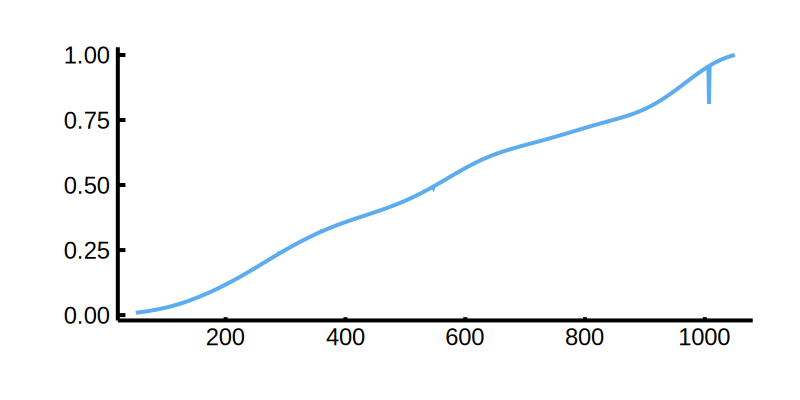

In [418]:
fig = plot(evals_pts, cdf_Hr, linecolor=:steelblue2, linewidth=1, 
        xtickfont=font(4), ytickfont=font(4), legend=nothing,
        foreground_color_legend=nothing, background_color_legend=nothing, grid=false)
plot!(size=(200,100))
savefig("cdf_Hr.png")
fig

<br><br><br><br>

## Step 4

### Estimate bid function for each bidder

In [419]:
bidders = sort(unique(dt.bidder))

pdf_b_i = []
cdf_b_i = [];

In [420]:
for b in bidders
    bids_i = exp.(dt_b[dt_b.bidder .== b, :b_norm])
    PDF_i(x) = est_pdf(bids_i, x)
    CDF_i(x) = est_cdf(bids_i, x)
    
    push!(pdf_b_i, PDF_i)
    push!(cdf_b_i, CDF_i)
end

### Estimate $\alpha_k$ (participation probabilities)

In [421]:
all_α_i = []

for b in bidders
    α_i = length(dt_b[dt_b.bidder .== b, :auction_num]) / length(unique(dt_b.auction_num))
    push!(all_α_i, α_i)
end

In [422]:
round.(all_α_i', digits=3)

1×11 Array{Float64,2}:
 0.571  0.094  0.243  0.08  0.217  0.036  0.036  0.012  0.055  0.007  0.007

### Construct $G_{-i}$

In [423]:
cdf_b_mi = []

for b in bidders
    bidders_mi = bidders[bidders .!= b]
    
    sum_α_mi = sum(all_α_i[bidders_mi])
    CDF_mi(x) = sum([all_α_i[i] * cdf_b_i[i](x) for i in bidders_mi]) / sum_α_mi
    push!(cdf_b_mi, CDF_mi)
end

In [424]:
cdf_b_mi[1](500)

0.8295176697674919

### Construct $g_{-i}$

In [425]:
pdf_b_mi = []

for b in bidders
    bidders_mi = bidders[bidders .!= b]
    
    sum_α_mi = sum(all_α_i[bidders_mi])
    PDF_mi(x) = sum([all_α_i[i] * pdf_b_i[i](x) for i in bidders_mi]) / sum_α_mi
    push!(pdf_b_mi, PDF_mi)
end

In [426]:
pdf_b_mi[1](500)

0.0009277280135584027

### Construct $v_{ik}$

In [435]:
eq_2 = function(hr, Hr, gmi, Gmi, b)
    num(x) = 0.5 .* Hr(x) .* (1.0 .- Gmi(x)) 
    denom(x) = hr(x) .* Gmi(x) .+ Hr(x) .* gmi(x)
    return (b .- num(b) ./ denom(b))[1]
end;

In [436]:
Gm_bids_obs = exp.(dt_b[(dt_b.bidder .!= 100) .& (dt_b.rank .== 1), :b_norm])
H̄r_bids_obs = exp.(dt_b[(dt_b.bidder .== 100) .& (dt_b.ring_wins .== 1.0), :b_norm])

hr(b) = fn_pdf_h(H̄r_bids_obs, Gm_bids_obs, b)
Hr(b) = fn_cdf_h(H̄r_bids_obs, Gm_bids_obs, b)

v_bidders = []

for bid in bidders
    gmi(b) = pdf_b_mi[bid](b)
    Gmi(b) = cdf_b_mi[bid](b)
    
    eq_2_i(b) = eq_2(hr, Hr, gmi, Gmi, b)
    push!(v_bidders, eq_2_i)
end

In [437]:
v_bidders[1](100)

23.827738690545857

### Figure 2

In [445]:
f2_eval = LinRange(250,1050,50);

In [463]:
values_b_1 = v_bidders[1].(f2_eval);
values_b_1 = values_b_1[values_b_1 .> 250];

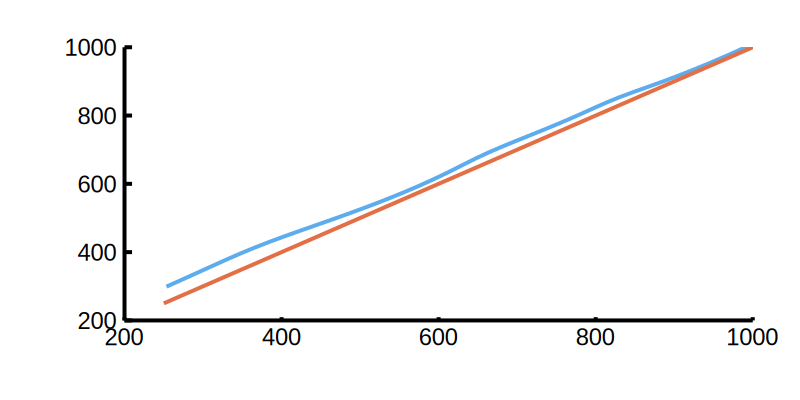

In [464]:
fig = plot(values_b_1, f2_eval[4:50], linecolor=:steelblue2, linewidth=1, 
        xtickfont=font(4), ytickfont=font(4), legend=nothing, yticks=[200:200:1000;], ylims=(200,1000),
        xticks=[200:200:1000;], xlims=(200,1000),
        foreground_color_legend=nothing, background_color_legend=nothing, grid=false)
plot!(f2_eval, f2_eval)
plot!(size=(200,100))
savefig("Fig_2_b_1.png")
fig